In [ ]:
!pip install torch torchvision
!pip install pandas scikit-learn

In [218]:
import platform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

import seaborn as sns

### Read data from .csv
One image is given as pixel-array with values in range [0, 255] (8-bit greyscale). The last column is the encoded class which is mapped below for clarity.

In [231]:
df = pd.read_csv('cifar10.csv')

images = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values

class_names = { 0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

### Hyperparameter
These parameters can be defined in an array. Later, each combination will be used as one training run; the best combination is then used for prediction.

**Batch Size:**    Number of samples per gradient update (smaller = noisier updates, larger = more stable but memory-heavy)\
**Learning Rate:** Step size for updating weights (too high = unstable, too low = slow learning)\
**Epochs:** Total number of passes through the entire training dataset\
**Momentum:** Momentum factor for SGD to smooth and accelerate gradients\
**Weight Decay:** L2 regularization strength to prevent overfitting by penalizing large weights\
**Dropout Rate:** Fraction of neurons randomly dropped during training to improve generalization

In [234]:
batch_sizes       = [64, 128]           
learning_rates    = [1e-3, 1e-4] 
num_epochs_values = [10, 15]
momentum_values   = [0.9, 0.95]
weight_decays     = [1e-5, 1e-4]
dropout_rates     = [0.3, 0.5]

In [222]:
def plot_class_distribution(labels, title, color):
    unique, counts = np.unique(labels, return_counts=True)    
    plt.figure(figsize=(6, 3))
    plt.bar([class_names[i] for i in unique], counts, color=color)
    plt.xlabel("class")
    plt.ylabel("# samples")
    plt.title(f"{title} Distribution")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
def plot_data_split_pie(train_size, val_size, test_size):
    sizes = [train_size, val_size, test_size]
    labels = ['Train', 'Validation', 'Test']
    
    def show_absolutes(pct, allvalues):
        absolute = int(pct/100.*sum(allvalues))
        return f"{absolute} ({pct:.1f}%)"
    
    plt.figure(figsize=(4, 4))
    plt.pie(sizes, labels=labels, autopct=lambda pct: show_absolutes(pct, sizes), startangle=90, colors=plt.cm.Paired.colors)
    plt.title("Train, Validation, and Test Data Split Distribution")
    plt.axis('equal')
    plt.show()

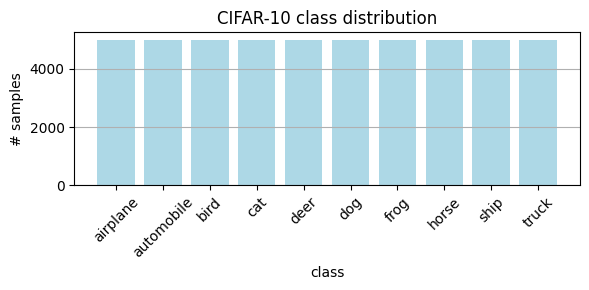

In [224]:
plot_class_distribution(labels, "CIFAR-10 class", "lightblue")

### Train-Test-Split
first split: 80% training, 20% (test + validation)

second split: 50% of the remaining 20% for validation, 50% for testing

Note: stratify keeps distribution equal.

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=24, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=24, stratify=y_temp)

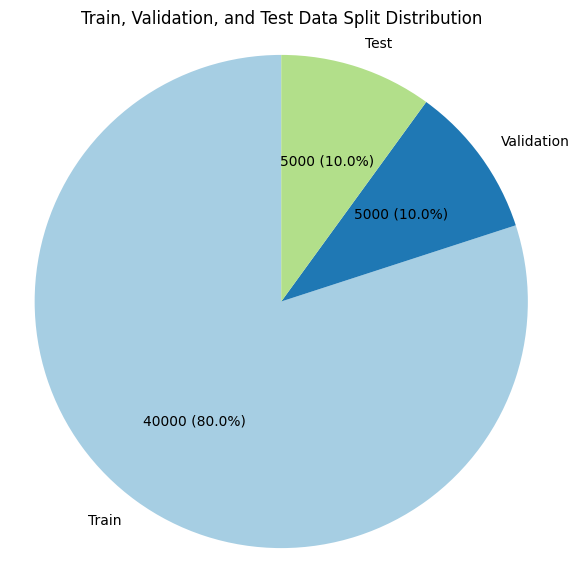

In [226]:
plot_data_split_pie(len(y_train), len(y_val), len(y_test))

### Data preparation for PyTorch SimpleCNN

#### Image preprocessing chaining with transforms.Compose

In [238]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalize for RGB values
])

#### Reshape images to (N, 3, 32, 32) where N is the number of samples, 3 the picture channels and 32x32 the scale (height x width)

In [ ]:
X_train = X_train.reshape(-1, 3, 32, 32) 
X_val   = X_val.reshape(-1, 3, 32, 32)
X_test  = X_test.reshape(-1, 3, 32, 32)

#### Convert images to tensor

In [239]:
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_data   = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_data  = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

#### Create DataLoader objects for batching
We shuffle the training data as we want to prevent overfitting by learning order patterns. The other data is unshuffled as we need consistent metricts for evaluation.

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False) 

### Define CNN model
It consists of three convolutional layers followed by ReLU activation and max-pooling, reducing the spatial dimensions of the input. After that, two fully connected layers are used to output class scores. Dropout is applied to the first fully connected layer to prevent overfitting. The model takes 32x32 RGB images as input and classifies them into 10 categories. The forward pass involves applying convolutions, activations, pooling, flattening the features, and passing through the fully connected layers.


Input (32x32x3)\
   |\
Conv1 (3->32, 3x3) -> ReLU -> MaxPool (2x2) -> (32x32x32)\
   |\
Conv2 (32->64, 3x3) -> ReLU -> MaxPool (2x2) -> (16x16x64)\
   |\
Conv3 (64->128, 3x3) -> ReLU -> MaxPool (2x2) -> (8x8x128)\
   |\
Flatten -> (4x4x128) -> 2048 units\
   |\
FC1 (2048->1024) -> ReLU\
   |\
Dropout (0.5)\
   |\
FC2 (1024->10) -> Output (10 classes)

In [241]:
class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)  # adjusted based on reduced image size after pooling
        self.fc2 = nn.Linear(1024, 10)  # 10 classes for CIFAR-10
        self.dropout = nn.Dropout(dropout_rate)  # dropout layer

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # apply dropout
        x = self.fc2(x)
        return x

#### Generate all hyperparameter combinations

In [ ]:
hyperparameter_combinations = list(product(batch_sizes, learning_rates, num_epochs_values, momentum_values, weight_decays, dropout_rates))
total_runs = len(hyperparameter_combinations)
results = []

best_model = None
best_val_accuracy = 0
best_hyperparameters = None

#### Train a SimpleCNN model for each hyperparameter combination, validate quality and output the best one

In [ ]:
for run_index, (batch_size, learning_rate, num_epochs, momentum, weight_decay, dropout_rate) in enumerate(hyperparameter_combinations):
    
    # create DataLoader for current batch size
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # initialize model and move it to device
    model = SimpleCNN(dropout_rate=dropout_rate).to(device)

    # loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    print(f"\n>>>>>>>>>>>>>>>>>Training run {run_index + 1}/{total_runs}")
    print(f"Hyperparameters: batch_size={batch_size}, learning_rate={learning_rate}, num_epochs={num_epochs}, "
      f"momentum={momentum}, weight_decay={weight_decay}, dropout_rate={dropout_rate}")
    print()

    # training loop
    for epoch in range(num_epochs):
        model.train()  # set to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        # training batch processing
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to selected device (GPU/CPU)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)
            
            # compute loss
            loss = criterion(outputs, labels)
            
            # backward pass and optimization with Adam
            loss.backward()
            optimizer.step()

            # track loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # validation accuracy after every epoch
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total

        # check if this is the best model so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model
            best_hyperparameters = (batch_size, learning_rate, num_epochs, momentum, weight_decay, dropout_rate)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
              f"Accuracy: {100 * correct/total:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

# after the loop, we have the best model
batch_size, learning_rate, num_epochs, momentum, weight_decay, dropout_rate = best_hyperparameters
print(f"Best model achieved with hyperparameters: {best_hyperparameters}, Validation Accuracy: {best_val_accuracy:.2f}%")


>>>>>>>>>>>>>>>>>Training run 1/64
Hyperparameters: batch_size=32, learning_rate=0.001, num_epochs=5, momentum=0.9, weight_decay=1e-05, dropout_rate=0.3

Epoch 1/5, Loss: 1.6226, Accuracy: 42.85%, Validation Accuracy: 51.82%
Epoch 2/5, Loss: 1.2487, Accuracy: 55.50%, Validation Accuracy: 58.56%
Epoch 3/5, Loss: 1.1108, Accuracy: 60.92%, Validation Accuracy: 63.04%
Epoch 4/5, Loss: 1.0267, Accuracy: 64.14%, Validation Accuracy: 62.82%
Epoch 5/5, Loss: 0.9523, Accuracy: 66.75%, Validation Accuracy: 63.06%

>>>>>>>>>>>>>>>>>Training run 2/64
Hyperparameters: batch_size=32, learning_rate=0.001, num_epochs=5, momentum=0.9, weight_decay=1e-05, dropout_rate=0.5

Epoch 1/5, Loss: 1.5972, Accuracy: 42.74%, Validation Accuracy: 52.26%
Epoch 2/5, Loss: 1.2493, Accuracy: 55.87%, Validation Accuracy: 60.32%
Epoch 3/5, Loss: 1.1243, Accuracy: 60.59%, Validation Accuracy: 63.68%
Epoch 4/5, Loss: 1.0589, Accuracy: 63.22%, Validation Accuracy: 65.10%
Epoch 5/5, Loss: 1.0079, Accuracy: 65.46%, Validati

#### Retrain the best model with the best hyperparameters

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
model = SimpleCNN(dropout_rate=dropout_rate).to(device)  # re-initialize model
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# final training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Final Training Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {100 * correct/total:.2f}%")

#### Evaluate the best model on the test set

In [ ]:
model.eval()
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy of the Best Model: {test_accuracy:.2f}%")

#### Spit out some metrices

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       500
           1       0.90      0.76      0.83       500
           2       0.70      0.54      0.61       500
           3       0.54      0.52      0.53       500
           4       0.68      0.74      0.71       500
           5       0.59      0.69      0.64       500
           6       0.70      0.83      0.76       500
           7       0.80      0.79      0.80       500
           8       0.80      0.87      0.84       500
           9       0.78      0.81      0.80       500

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.73      0.73      0.73      5000



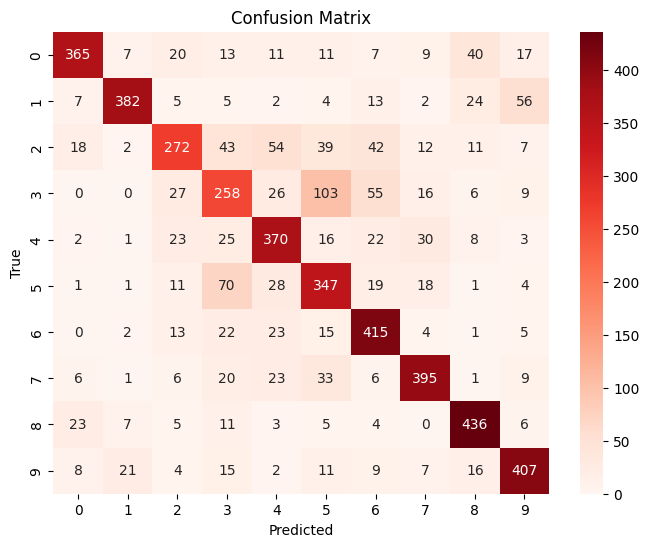

In [243]:
model.eval() # evaluation mode

# initialize lists to store all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # store the predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# calculate overall accuracy
accuracy = accuracy_score(all_labels, all_preds)

# compute Precision, Recall, F1 Score (weighted for multi-class classification)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print("Classification Report:")
print(classification_report(all_labels, all_preds))

# confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()